# PLL PI Control

In [184]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [185]:
plt.rcParams['figure.figsize'] = [16, 8]

### `scipy.signal.step` Step-Response Demo

From [SciPy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step.html#scipy.signal.step)

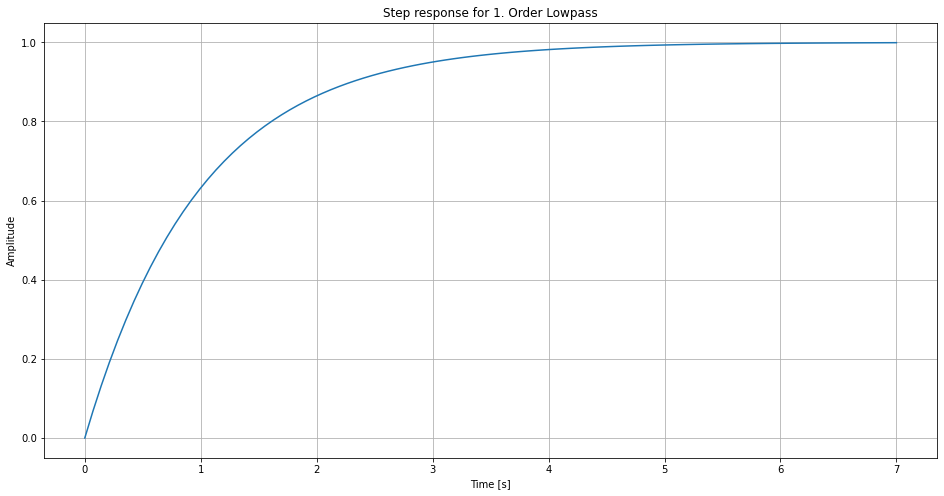

In [186]:
lti = signal.lti([1.0], [1.0, 1.0])
t, y = signal.step(lti)
plt.plot(t, y)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Step response for 1. Order Lowpass')
plt.grid()

### Continuous-Time Proportional-Integral Controller 

General PI-controlled system, using this [CalTech Notation](https://www.cds.caltech.edu/~murray/courses/cds101/fa04/caltech/am04_ch8-3nov04.pdf):

```
P(s) = b / (s+a)
C(s) = kp + ki/s

Hcl(s) = P(s)F(s) / (1 + P(s)F(s))
       = b*(kp*s + ki) / (s**2 + (a+b*kp)s + b*ki)
```

### Application to the Digital PLL 

For the PI-control PLL:

```
b = M*Kd
a => 0   # DCO is a perfect integrator

Hpll(s) = M*Kd*(kp*s+ki) / (s**2 + M*Kd*kp*s + M*Kd*ki)
```

Derivations:

```
w0 = sqrt(M*Kd*Ki)
Q  = sqrt(ki/M/Kd)/Kp
td = Q / w0 
   = 1 / M / Kd / Kp
```

In [187]:
from dataclasses import dataclass

@dataclass
class PiPll(object):
    M:  float = 1.0
    Kd: float = 1.0
    ki: float = 1.0
    kp: float = 1.0
        
    @property
    def params(self):
        return (self.M, self.Kd, self.ki, self.kp)
    
    @staticmethod
    def tf(M, Kd, ki, kp):
        num = [M*Kd*kp, M*Kd*ki]
        den = [1, M*Kd*kp, M*Kd*ki]
        return num, den
        
    def calc(self): 
        """ Calculate all of our internal derived quantities
        Transfer function, bandwidth, Q, etc. """
        self.num, self.den = self.tf(*self.params)
        
        self.w0 = np.sqrt(self.M*self.Kd*self.ki)
        self.tm = 0.1 * 1/2/np.pi/self.w0
        self.Q = np.sqrt(self.ki/self.M/self.Kd)/self.kp
        self.td = self.Q / self.w0
        
    def plot(self):
        """ Plot our step response """
        lti = signal.lti(self.num, self.den)
        
        # Plot over a few time-constants
        # Note we'll need many more points with high-Q, 
        # or often plots will alias and look under-damped! 
        npoints = max(1000, int(1000*self.Q))
        timescale = np.linspace(0, 10*self.td, npoints)
        
        t, y = signal.step(lti, T=timescale)
        label=f'w0={self.w0:.2e} Q={self.Q:.2e}, td={self.td:.2e}'
        plt.plot(t, y, label=label)
        plt.legend()
        plt.grid()


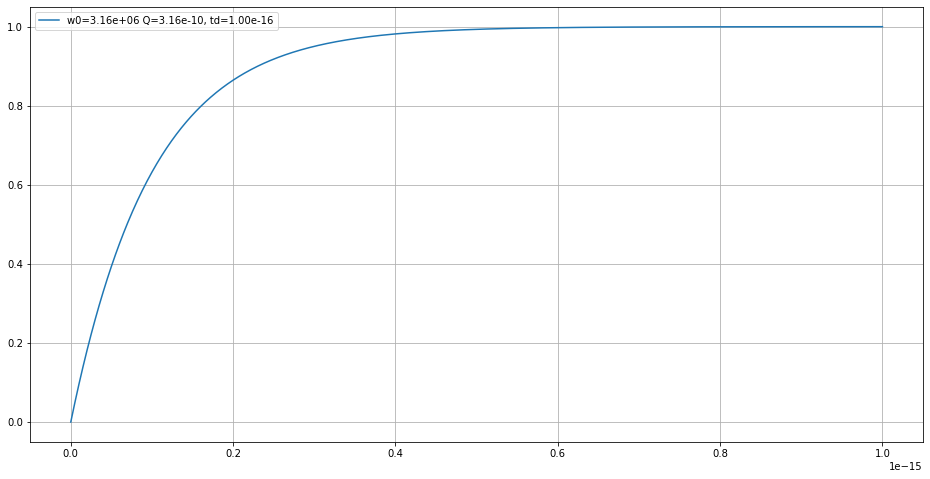

In [188]:
pll = PiPll(M=1, Kd=1e10, ki=1e3, kp=1e6)
pll.calc()
pll.plot()

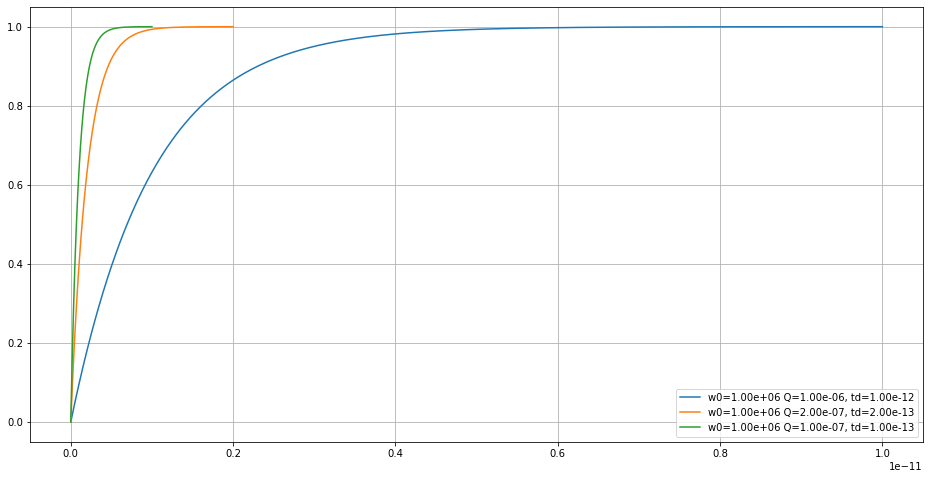

In [189]:
for kp in [1, 5, 10]:
    pll = PiPll(M=1e6, Kd=1e6, ki=1, kp=kp)
    pll.calc()
    pll.plot()

## Discrete-Time View

In [190]:
from dataclasses import dataclass, field
import copy 

@dataclass
class LoopState(object):
    dco_phase: int = 0
    targ_phase: int = 0 
    accum: int = 0
    accum_m1: int = 0
    dctrl: int = 0
    f: float = 0 #3e9
        
@dataclass
class Loop(object):
        
    f0: float = 0 #3e9
    kdco: float = 5e3
    nstg: int = 15 
    mult: int = 32
    ref_period: float = 10e-9
    ki: float = 40
    kp: float = 400
        
    state: LoopState = field(default_factory=LoopState)
    history: list = field(default_factory=list)
        
    def update(self):
        past = copy.copy(self.state)
        self.history.append(past)
        self.state.targ_phase = past.targ_phase + 2 * self.nstg * self.mult
        
        # How many gate-delays in a refclk cycle:
        incr_phase = 2 * self.nstg * self.ref_period * \
            (self.f0 + self.kdco * past.dctrl) 

        self.state.dco_phase = past.dco_phase + incr_phase
        err = self.state.targ_phase - self.state.dco_phase

        self.state.accum_m1 = past.accum
        self.state.accum = self.state.accum_m1 + err
        self.state.dctrl = self.state.accum * self.ki + err * self.kp
        self.state.f = self.state.dctrl * self.kdco + self.f0
    
    def run(self, ncyc:int=100):
        for _ in range(ncyc): self.update()
    
    def plot(self, **kwargs):
        f = [e.f for e in self.history]
        plt.plot(f, **kwargs)
        

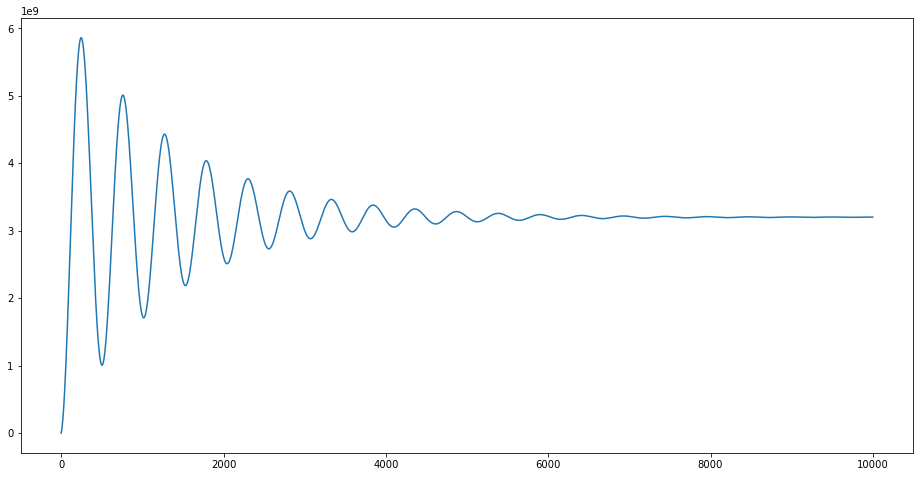

In [191]:
l = Loop(ki=0.1, kp=1)
l.run(10000)
l.plot()

Sweeping `Kp`, and looking at some clearly very underdamped responses. 

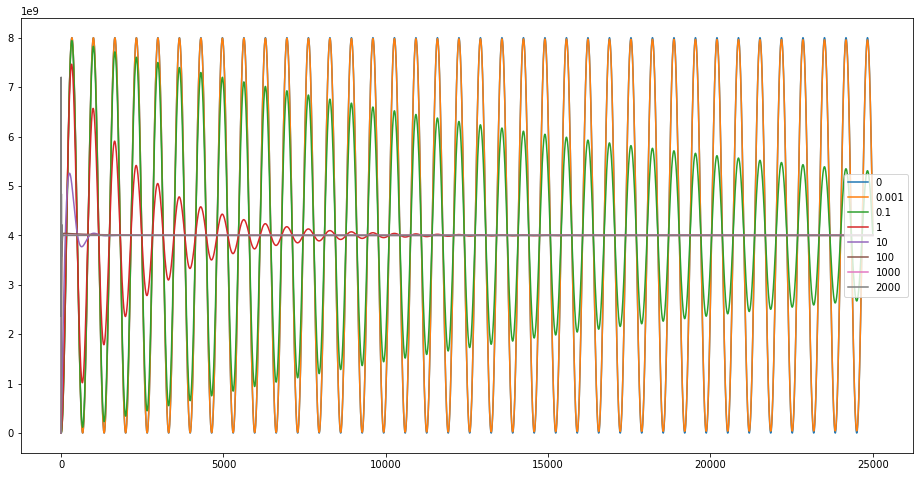

In [192]:
for kp in (0, 0.001, 0.1, 1, 10, 100, 1000, 2000):
    l = Loop(state=LoopState(), ki=0.1, kp=kp, mult=40, kdco=3e3)
    l.run(25000)
    l.plot(label=kp)
plt.legend(loc=7)

Note the oscillation frequency is independent of `Kp`. The damping increases with `Kp` over this range. Setting `Kp=0` generates a lossless oscillator. 

A more realistic range of potential `Kp` values:

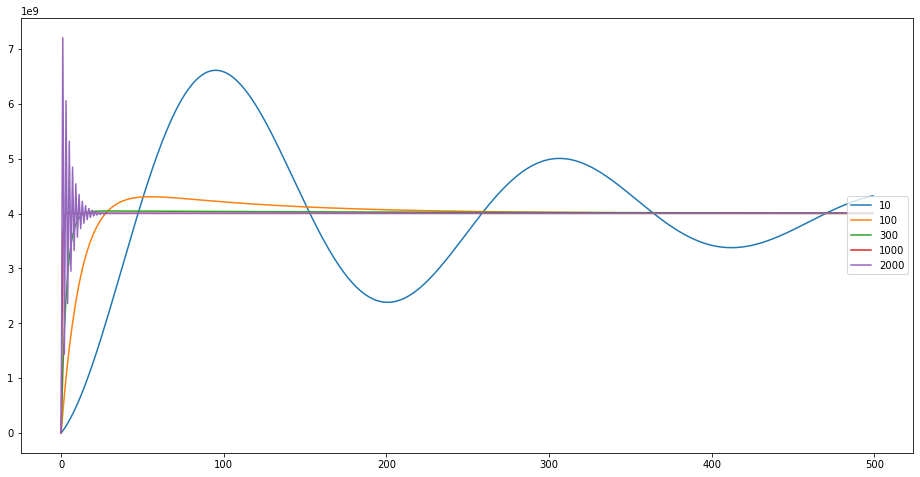

In [193]:
for kp in (10, 100, 300, 1000, 2000):
    l = Loop(state=LoopState(), ki=1, kp=kp, mult=40, kdco=3e3)
    l.run(500)
    l.plot(label=kp)
plt.legend(loc=7)

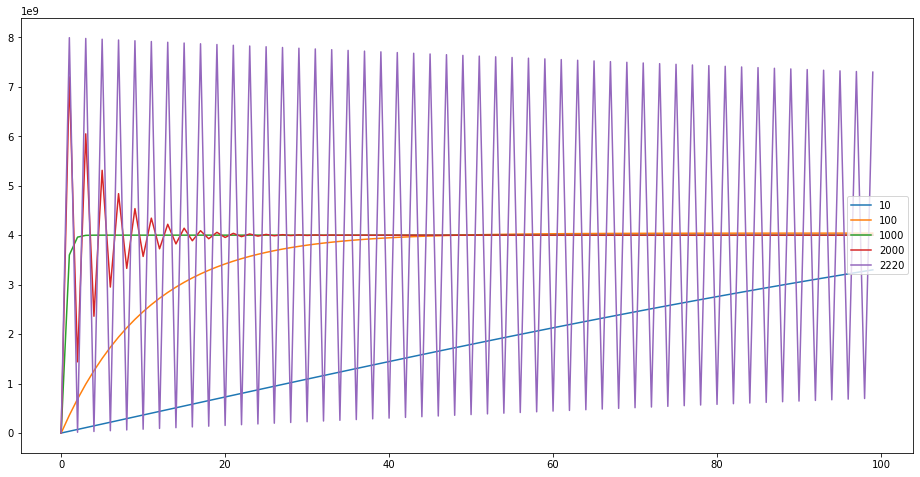

In [194]:
for kp in (10, 100, 1000, 2000, 2220):
    l = Loop(state=LoopState(), ki=0.1, kp=kp, mult=40, kdco=3e3)
    l.run(100)
    l.plot(label=kp)
plt.legend(loc=7)

With these parameter-values, `Kt = kdco*Tref*2*Nstg` is about 0.001. Setting `Kp = 1/Kt` to about 1000 maximizes our bandwidth. Setting `Kp` only slightly higher than `1/Kt` causes the high-frequency oscillations seen in red. Setting `Kp` to `2/Kt` moves our pole back onto the unit-circle, at z=-1. Greater values of `Kp` lead to oscillation. 

All told, the useful range of `Kp` values lies between roughly `0.1/Kt` and `1/Kt`:

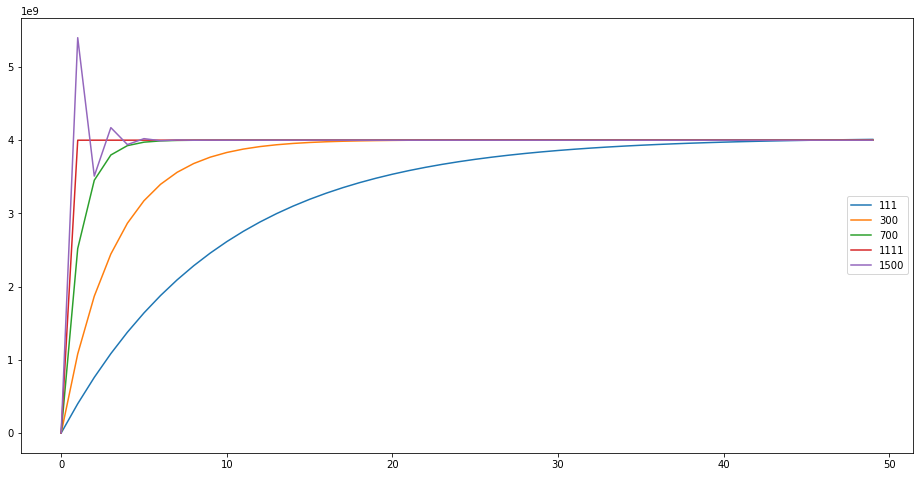

In [195]:
for kp in (111, 300, 700, 1111, 1500):
    l = Loop(state=LoopState(), ki=0.1, kp=kp, mult=40, kdco=3e3)
    l.run(50)
    l.plot(label=kp)
plt.legend(loc=7)

A fun fact about this arrangement: the loop dynamics are essentially independent of the frequency-multiplication ratio `M`. Sweeping `M` over a nearly 4:1 range:

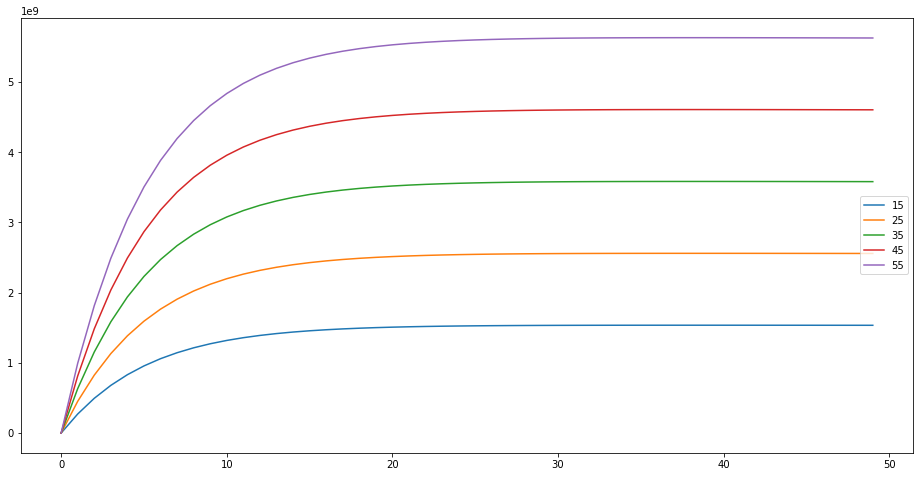

In [196]:
for mult in (15,25,35,45,55):
    l = Loop(state=LoopState(), ki=1, kp=200, mult=mult, kdco=3e3)
    l.run(50)
    l.plot(label=mult)
plt.legend(loc=7)

Note these plots are for a fixed `Tref`, i.e. the programmed DCO frequency increases in prooprtion with `M`, between 1.5 and 5.5 GHz. `Tref` does impact the loop dynamics, by changing the incremental phase incremented per cycle. To the extent that a realistic `Kdco` would depend on its frequency, this would also impact the dynamics. 

## `scipy.dlti` Models

First a demo of scipy's z-domain step-response tool, `scipy.signal.dlti`:

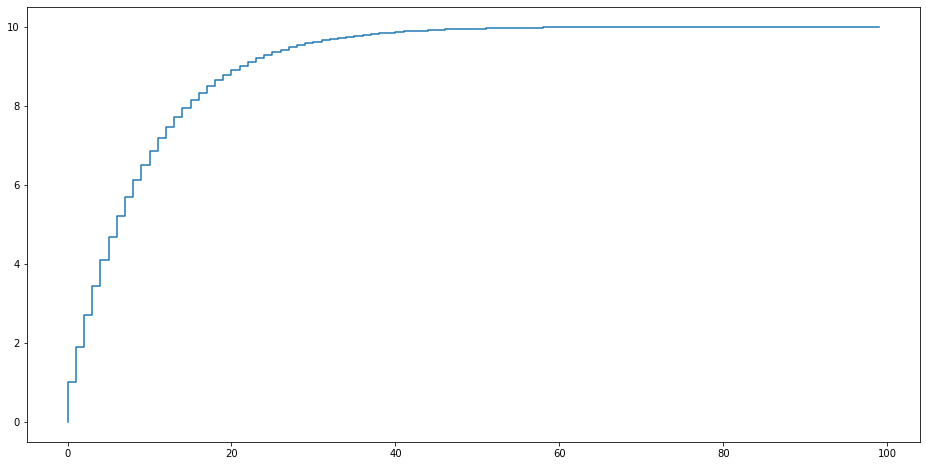

In [197]:
lti = signal.dlti([1.0, 0], [1.0, -0.9, 0])
t, y = signal.dstep(lti)
plt.step(t, np.squeeze(y))

Now, a z-plane model of our system (which doesn't seem to to totally square yet):

In [198]:
Kt = 2*15*3e3*10e-9
Ki = 0.1
Kp = 100

In [199]:
def pllz():
    """ Caclulate this PLL's z-domain transfer. 
    Returns a two-tuple of `num, den` numpy arrays. 
    Loop parameter-values are captured from the calling context. """
    return np.array([Kt*(Ki+Kp), -1*Kp*Kt]), np.array([1.0, Kt*(Ki+Kp)-2, 1-Kp*Kt])
pllz()

(array([ 0.09009, -0.09   ]), array([ 1.     , -1.90991,  0.91   ]))

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.figure import Figure
from matplotlib import rcParams
import itertools
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

def zplane(b, a, ax=None, **kwargs):
    """ Plot the complex z-plane given a transfer function """

    # get a figure/plot
    if ax is None:
        _, ax = plt.subplots()
    color = next(colors)

    # create the unit circle
    uc = patches.Circle((0,0), radius=1, fill=False,
                        color='black', ls='dashed')
    ax.add_patch(uc)

    # The coefficients are less than 1, normalize the coeficients
    if np.max(b) > 1:
        kn = np.max(b)
        b = b/float(kn)
    else:
        kn = 1

    if np.max(a) > 1:
        kd = np.max(a)
        a = a/float(kd)
    else:
        kd = 1
        
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)
    k = kn/float(kd)
    
    # Plot the zeros and set marker properties    
    t1 = ax.plot(z.real, z.imag, color=color, marker='o', ms=20, ls='None', **kwargs)
    # Plot the poles 
    t2 = ax.plot(p.real, p.imag, color=color, marker='x', ms=20, ls='None')

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set the ticks
    r = 2.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
    ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks)

    return ax


<AxesSubplot:>

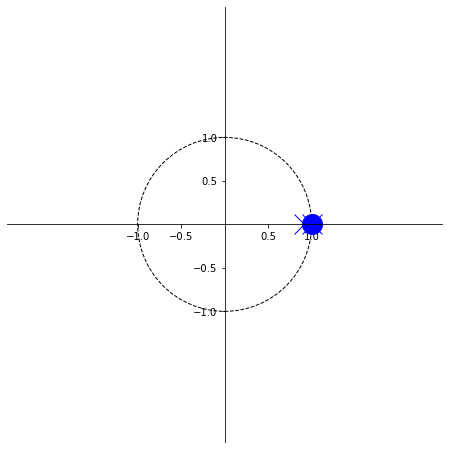

In [201]:
zplane(*pllz())

In [202]:
def pll_no_kp():
    """ Transfer of the (very unstable) loop with Kp=0 """
    return [Ki*Kt, 0], [1, Ki*Kt-2, 1]
pll_no_kp()

([9e-05, 0], [1, -1.99991, 1])

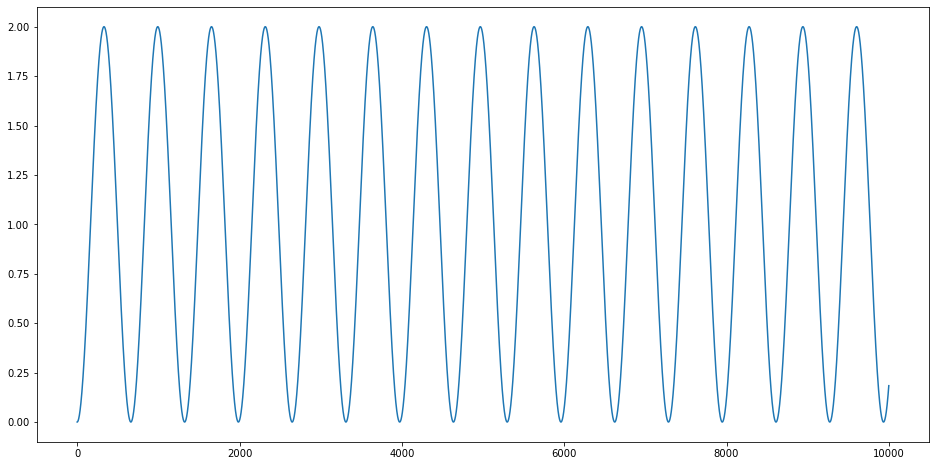

In [203]:
lti = signal.dlti(*pll_no_kp())
t, y = signal.dstep(lti, n=10000)
plt.plot(t, np.squeeze(y), label=Kp)

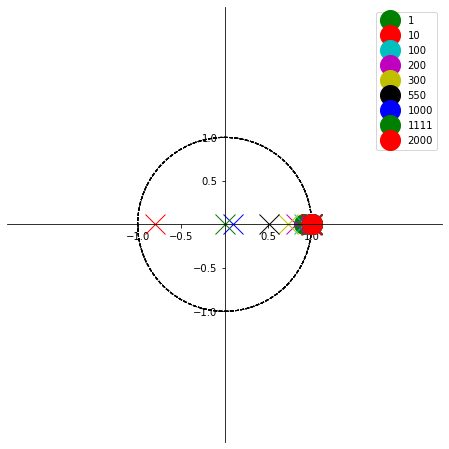

In [204]:
ax = None
for Kp in (1, 10, 100, 200, 300, 550, 1000, 1111, 2000):
    ax = zplane(*pllz(), ax, label=Kp)
plt.legend()

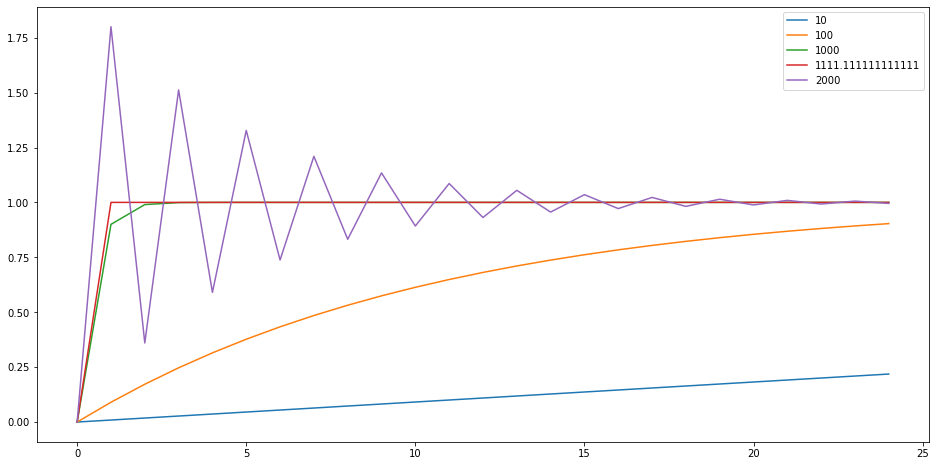

In [205]:
for Kp in (10, 100, 1000, 1111.111111111111, 2000):
    lti = signal.dlti(*pllz())
    t, y = signal.dstep(lti, n=25)
    plt.plot(t, np.squeeze(y), label=Kp)
plt.legend()

<AxesSubplot:>

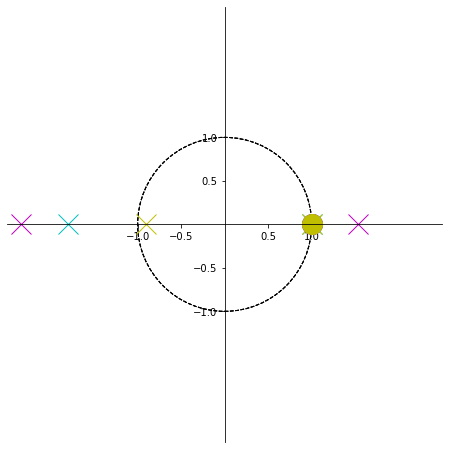

In [206]:
ax = zplane(np.array([Kt*(Ki+Kp), -1*Kp*Kt]), np.array([1.0, Kt*(Ki+Kp)-1, -1*Kp*Kt]))
zplane(np.array([Kt*(Ki+Kp), -1*Kp*Kt]), np.array([1.0, Kt*(Ki+Kp)-1, -2*Kp*Kt]), ax)
zplane(np.array([Kt*(Ki+Kp), -1*Kp*Kt]), np.array([1.0, 0.5*Kt*(Ki+Kp)-1, -0.5*Kp*Kt]), ax)

## TDC & Divider Edition

Some of our past notation may have been atypicaly, since it assumed the *phase sampling DCO* architecture. A more traditional architecture with a feedback divider and TDC-based phased detector has a similar transfer function:

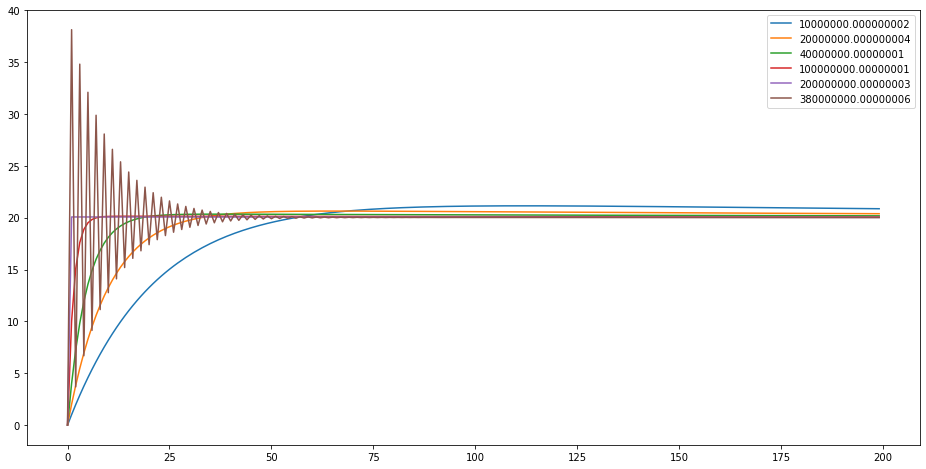

In [207]:
@dataclass
class TdcPll:
    ktdc: float
    kdco: float
    ki: float
    kp: float
    divn: int
    
    def tf(self):
        num = np.array([self.ktdc*self.kdco*(self.ki+self.kp), -1*self.kp*self.ktdc*self.kdco])
        den = np.array([1.0, self.ktdc*self.kdco/self.divn*(self.ki+self.kp)-2, 1-(self.kp*self.ktdc*self.kdco/self.divn)])
        return (num, den)

kdco = 1e4
ktdc = 10e-12
divn = 20
kp_max = divn/kdco/ktdc
ki_ratio = 256 # kp/ki

for kp in (kp_max/20, kp_max/10, kp_max/5, kp_max/2, kp_max, 1.9*kp_max): 
    pll = TdcPll(kdco=kdco, ktdc=ktdc, ki=kp/ki_ratio, kp=kp, divn=divn)
    lti = signal.dlti(*pll.tf())
    t, y = signal.dstep(lti, n=200)
    plt.plot(t, np.squeeze(y), label=kp)
    plt.legend()

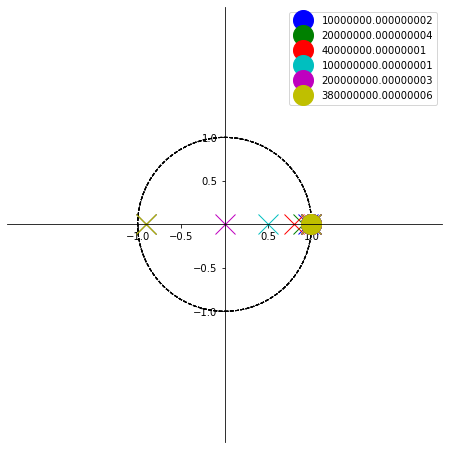

In [208]:
pll = TdcPll(kdco=kdco, ktdc=ktdc, ki=kp/ki_ratio, kp=kp, divn=divn)
ax = zplane(*pll.tf())

for kp in (kp_max/20, kp_max/10, kp_max/5, kp_max/2, kp_max, 1.9*kp_max): 
    pll = TdcPll(kdco=kdco, ktdc=ktdc, ki=kp/ki_ratio, kp=kp, divn=divn)
    ax = zplane(*pll.tf(), ax, label=kp)
ax.legend()

## Integral-Only FLL

Similar treatment of a frequency-measuring phase(? frequency?) locked loop.

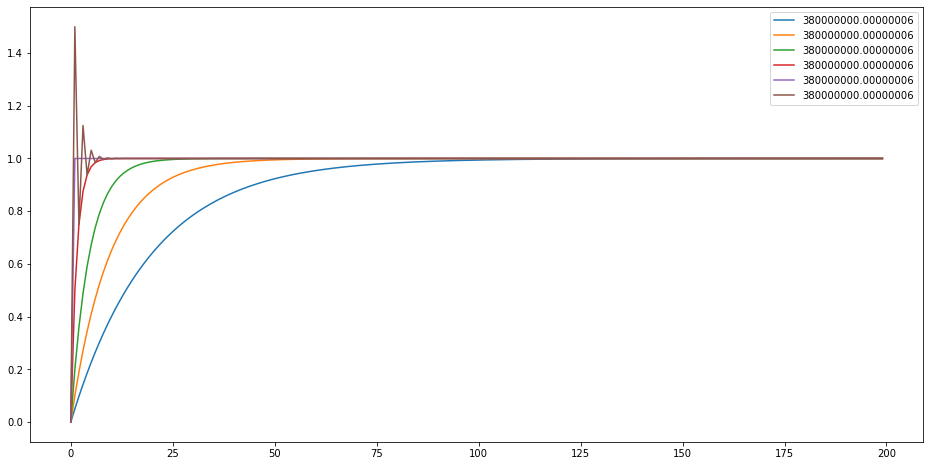

In [216]:
@dataclass
class IntegFll:
    kdco: float
    ki: float
    
    def tf(self):
        num = np.array([self.kdco * self.ki])
        den = np.array([1.0, self.ki*self.kdco - 1])
        return (num, den)

kdco = 1e6
ki_max = 1/kdco

for ki in (ki_max/20, ki_max/10, ki_max/5, ki_max/2, ki_max, 1.5*ki_max): 
    pll = IntegFll(ki=ki, kdco=kdco)
    lti = signal.dlti(*pll.tf())
    t, y = signal.dstep(lti, n=200)
    plt.plot(t, np.squeeze(y), label=kp)
    plt.legend()